**Drive de google.colab**

In [1]:
# Montar Drive (si no está montado)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Importación y configuración.**

In [2]:
# === IMPORTS ===
import os
import numpy as np
import pandas as pd

from statsmodels.tsa.statespace.structural import UnobservedComponents
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Ruta de origen y lectura
ruta = "/content/drive/MyDrive/Proyecto Integrador TEC 2025/EDA/nacional_semanal.csv"
df = pd.read_csv(ruta)

**Visualización previa**

In [4]:
df.head(5)

,Fecha,Nuevos_Casos
0,2014-01-05,11.0
1,2014-01-12,89.0
2,2014-01-19,127.0
3,2014-01-26,114.0
4,2014-02-02,159.0


**Configuración y series de trabajo**

In [5]:
S = 52  # periodicidad semanal

# Copia y ordena el DataFrame original
df_model = df.copy().sort_values("Fecha").reset_index(drop=True)

# Serie objetivo
y = df_model.set_index("Fecha")["Nuevos_Casos"].astype(float)

# Asegura índice tipo datetime y orden temporal
y.index = pd.to_datetime(y.index)
y = y.sort_index()

# División temporal (train / test)
TEST_WEEKS = 52
cut = max(len(y) - TEST_WEEKS, 1)
y_train, y_test = y.iloc[:cut], y.iloc[cut:]

# Asegurar que ambos índices son datetime
y_train.index = pd.to_datetime(y_train.index)
y_test.index = pd.to_datetime(y_test.index)

# === Verificación
print(f"Tamaño total: {len(y)} | Train: {len(y_train)} | Test: {len(y_test)}")
print(f"Train desde {y_train.index.min().date()} hasta {y_train.index.max().date()}")
print(f"Test  desde {y_test.index.min().date()} hasta {y_test.index.max().date()}")


Tamaño total: 573 | Train: 521 | Test: 52
Train desde 2014-01-05 hasta 2023-12-24
Test  desde 2023-12-31 hasta 2024-12-22


**Métricas (MAE, sMAPE, MASE)**

In [6]:
def mae(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    return float(np.mean(np.abs(y_true[mask] - y_pred[mask])))

# Métricas
def smape(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    den = np.maximum(np.abs(y_true) + np.abs(y_pred), eps)  # evita división por 0
    return float(200.0 * np.mean(np.abs(y_pred - y_true) / den))

def mase(y_train, y_true, y_pred, m=52):  # semanal: m=52
    y_train = np.asarray(y_train, dtype=float)
    y_true  = np.asarray(y_true,  dtype=float)
    y_pred  = np.asarray(y_pred,  dtype=float)

    # limpiar
    y_train = y_train[np.isfinite(y_train)]

    # escala con error del naïve estacional (TRAIN)
    if len(y_train) > m:
        diff = y_train[m:] - y_train[:-m]
        diff = diff[np.isfinite(diff)]
        scale = np.mean(np.abs(diff)) if diff.size else np.nan
    else:
        # fallback si la serie es corta
        yt = y_train
        scale = np.mean(np.abs(np.diff(yt))) if yt.size > 1 else np.nan

    if not np.isfinite(scale) or scale == 0:
        return float('nan')

    # MAE del modelo en el segmento de evaluación
    mask_ev = np.isfinite(y_true) & np.isfinite(y_pred)
    mae_model = np.mean(np.abs(y_true[mask_ev] - y_pred[mask_ev])) if np.any(mask_ev) else np.nan

    return float(mae_model / scale) if np.isfinite(mae_model) else float('nan')

**Fourier (para estacionalidad flexible en ARIMA/SARIMAX)**

In [7]:
def fourier(df_index, m=S, K=2):
    """Devuelve DataFrame con senos/cosenos para K armónicos."""
    t = np.arange(len(df_index))
    feats = {}
    for k in range(1, K+1):
        feats[f'sin_{k}'] = np.sin(2*np.pi*k*t/m)
        feats[f'cos_{k}'] = np.cos(2*np.pi*k*t/m)
    return pd.DataFrame(feats, index=df_index)

**Interfaz base y registro de modelos**

In [8]:
class BaseForecaster:
    def fit(self, y_train: pd.Series, exog: pd.DataFrame | None = None): ...
    def predict(self, steps: int, exog: pd.DataFrame | None = None) -> pd.Series: ...

REGISTRY = {}  # nombre -> clase
def register(name):
    def _wrap(cls):
        REGISTRY[name] = cls
        return cls
    return _wrap

**ETS (Holt–Winters LINEA BASE)**

In [9]:
@register("ETS")
class ETSForecaster(BaseForecaster):
    def __init__(self, trend="add", damped_trend=False, seasonal=None, seasonal_periods=52):
        # Misma configuración que el modelo Holt aditivo
        self.kw = dict(
            trend=trend,
            damped_trend=damped_trend,
            seasonal=seasonal,
            seasonal_periods=seasonal_periods,
            initialization_method="estimated"  # Igual que en la línea base
        )
        self.model_ = None

    def fit(self, y_train):
        # Igualamos los parámetros de ajuste (optimized + use_brute)
        self.model_ = ExponentialSmoothing(y_train, **self.kw).fit(
            optimized=True, use_brute=True
        )
        self.index_train_ = y_train.index
        return self

    def predict(self, steps):
        # Mantiene la misma frecuencia semanal (W-SUN)
        idx = pd.date_range(
            self.index_train_[-1] + pd.offsets.Week(weekday=6),
            periods=steps,
            freq="W-SUN"
        )
        fc = self.model_.forecast(steps)
        return pd.Series(fc.values, index=idx, name="yhat")

**SARIMA (SARIMAX sin exógenas)**

In [10]:
@register("SARIMA")
class SARIMAForecaster(BaseForecaster):
    def __init__(self, order=(1,1,1), seasonal_order=(0,0,0,52), transform=None):
        self.order = order
        self.seasonal_order = seasonal_order
        self.transform = transform
        self.res_ = None
        self.endog_index_ = None
        self.freq_ = None
        self.exog_cols_ = None  # columnas esperadas de exógenas con residuos

    def _apply_transform(self, y):
        if self.transform == "log":
            return np.log(y)
        elif self.transform == "log1p":
            return np.log1p(y)
        return y

    def _invert_transform(self, arr):
        if self.transform == "log":
            return np.exp(arr)
        elif self.transform == "log1p":
            return np.expm1(arr)
        return arr

    def fit(self, y_train, exog: pd.DataFrame | None = None):
        y_train = pd.Series(y_train.astype(float), index=pd.to_datetime(y_train.index))
        y_t = self._apply_transform(y_train)

        # Guarda índice y frecuencia para construir horizontes coherentes
        self.endog_index_ = y_train.index
        self.freq_ = self.endog_index_.freq or pd.infer_freq(self.endog_index_)
        if self.freq_ is None:
            # fallback razonable semanal
            self.freq_ = "W-SUN"

        # Alinear exógenas al TRAIN
        if exog is not None:
            exog = exog.reindex(self.endog_index_).fillna(0)
            self.exog_cols_ = list(exog.columns)
        else:
            self.exog_cols_ = None

        mod = SARIMAX(
            y_t,
            exog=exog,
            order=self.order,
            seasonal_order=self.seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        self.res_ = mod.fit(disp=False)
        return self

    def predict(self, steps: int, exog: pd.DataFrame | None = None):
        # Si el modelo fue entrenado con exógenas, garantizar que el futuro tenga mismas columnas
        if self.exog_cols_ is not None:
            if exog is None:
                # construir exógenas futuras en ceros
                future_idx = pd.date_range(
                    self.endog_index_[-1] + pd.tseries.frequencies.to_offset(self.freq_),
                    periods=steps,
                    freq=self.freq_,
                )
                exog = pd.DataFrame(0, index=future_idx, columns=self.exog_cols_)
            else:
                # asegurar columnas y orden
                exog = exog.reindex(columns=self.exog_cols_).fillna(0)
                # si no trae índice, lo generamos
                if exog.index.dtype != "datetime64[ns]":
                    future_idx = pd.date_range(
                        self.endog_index_[-1] + pd.tseries.frequencies.to_offset(self.freq_),
                        periods=steps,
                        freq=self.freq_,
                    )
                    exog.index = future_idx

        fc = self.res_.get_forecast(steps=steps, exog=exog)
        fc_values = fc.predicted_mean.values
        fc_values = self._invert_transform(fc_values)

        # índice futuro
        if exog is not None and isinstance(exog.index, pd.DatetimeIndex):
            idx = exog.index
        else:
            idx = pd.date_range(
                self.endog_index_[-1] + pd.tseries.frequencies.to_offset(self.freq_),
                periods=steps,
                freq=self.freq_,
            )
        return pd.Series(fc_values, index=idx, name="yhat")

**ARIMA + Fourier (estacionalidad flexible)**

In [11]:
@register("ARIMA_FOURIER")
class ARIMAFourierForecaster(BaseForecaster):
    def __init__(self, order=(1,1,1), K=2, m=S):
        self.order = order; self.K = K; self.m = m
        self.res_ = None; self.last_index_ = None
    def fit(self, y_train):
        X = fourier(y_train.index, m=self.m, K=self.K)
        self.last_index_ = y_train.index
        mod = SARIMAX(y_train, order=self.order, seasonal_order=(0,0,0,0),
                      exog=X, enforce_stationarity=False, enforce_invertibility=False)
        self.res_ = mod.fit(disp=False)
        return self
    def predict(self, steps):
        idx = pd.date_range(self.last_index_[-1] + pd.offsets.Week(weekday=6),
                            periods=steps, freq="W-SUN")
        Xf = fourier(idx, m=self.m, K=self.K)
        fc = self.res_.get_forecast(steps=steps, exog=Xf)
        return pd.Series(fc.predicted_mean.values, index=idx, name="yhat")

**UCM (tendencia + estacionalidad opcional)**

In [12]:
@register("UCM")
class UCMForecaster(BaseForecaster):
    def __init__(self, level="local linear trend", seasonal=S, irregular=True):
        self.level = level; self.seasonal = seasonal; self.irregular = irregular
        self.res_ = None; self.end_ = None
    def fit(self, y_train):
        self.end_ = y_train.index
        mod = UnobservedComponents(y_train, level=self.level,
                                   seasonal=self.seasonal, irregular=self.irregular)
        self.res_ = mod.fit(disp=False)
        return self
    def predict(self, steps):
        fc = self.res_.get_forecast(steps=steps)
        idx = pd.date_range(self.end_[-1] + pd.offsets.Week(weekday=6),
                            periods=steps, freq="W-SUN")
        return pd.Series(fc.predicted_mean.values, index=idx, name="yhat")

**STL + ARIMA (modelo sobre residuo; la estacionalidad se quita vía STL)**

In [13]:
@register("STL_ARIMA")
class STL_ARIMA_Forecaster(BaseForecaster):
    def __init__(self, period=S, order=(1,1,1)):
        self.period = period; self.order = order
        self.stl_ = None; self.res_ = None; self.last_index_ = None
        self.trend_ = None; self.seasonal_ = None
    def fit(self, y_train):
        self.last_index_ = y_train.index
        self.stl_ = STL(y_train, period=self.period, robust=True).fit()
        resid = y_train - self.stl_.seasonal
        self.trend_ = self.stl_.trend
        self.seasonal_ = self.stl_.seasonal
        mod = SARIMAX(resid, order=self.order, seasonal_order=(0,0,0,0),
                      enforce_stationarity=False, enforce_invertibility=False)
        self.res_ = mod.fit(disp=False)
        return self
    def predict(self, steps):
        # proyección: residuo + última estacionalidad conocida
        idx = pd.date_range(self.last_index_[-1] + pd.offsets.Week(weekday=6),
                            periods=steps, freq="W-SUN")
        resid_fc = self.res_.get_forecast(steps=steps).predicted_mean
        # repetir patrón estacional de longitud S
        seas_tail = pd.Series(self.seasonal_.values[-self.period:], index=self.seasonal_.index[-self.period:])
        seas_fc = pd.Series(np.resize(seas_tail.values, steps), index=idx)
        return pd.Series(resid_fc.values + seas_fc.values, index=idx, name="yhat")

**Función para ejecutar modelo por nombre + hiperparámetros**

In [14]:
import numpy as np  # asegúrate de tenerlo importado

def rmse(y_true, y_pred):
    return float(np.sqrt(np.mean((np.asarray(y_true) - np.asarray(y_pred))**2)))

def run_model(model_name: str, **kwargs):
    if model_name not in REGISTRY:
        raise ValueError(f"Modelo '{model_name}' no está registrado. Opciones: {list(REGISTRY)}")

    # Extrae exógenas del TRAIN
    exog_train = kwargs.pop("exog", None)

    # Instancia el forecaster con el resto de parámetros
    model = REGISTRY[model_name](**kwargs)

    # Fit
    used_exog = False
    if exog_train is not None:
        exog_aligned = exog_train.reindex(y_train.index).fillna(0)
        try:
            model = model.fit(y_train, exog=exog_aligned)
            used_exog = True
        except TypeError:
            model = model.fit(y_train)
    else:
        model = model.fit(y_train)

    # Horizonte
    steps = len(y_test)

    # Predict
    if used_exog:
        exog_future = pd.DataFrame(0, index=y_test.index, columns=exog_aligned.columns)
        try:
            yhat = model.predict(steps=steps, exog=exog_future)
        except TypeError:
            yhat = model.predict(steps=steps)
    else:
        yhat = model.predict(steps=steps)

    # Alinear por índice
    y_true = y_test.loc[yhat.index.intersection(y_test.index)]
    y_pred = yhat.loc[y_true.index]

    # Métricas (incluye RMSE)
    out = {
        "model": model_name,
        "params": kwargs,
        "MAE": mae(y_true, y_pred),
        "RMSE": rmse(y_true, y_pred),      # ← agregado
        "sMAPE": smape(y_true, y_pred),
        "MASE": mase(y_train, y_true, y_pred, m=S),
    }

    return out, y_pred

**Creación de exogenas residuales**

In [15]:
# creación de exógenas (shocks)
# Re-fit del modelo SARIMA base para obtener residuales
mdl_tmp = SARIMAForecaster(order=(2,0,1), seasonal_order=(0,1,1,S), transform="log1p").fit(y_train)
resid = pd.Series(mdl_tmp.res_.resid, index=mdl_tmp.endog_index_)

# Identificar las TOP-3 semanas con mayores outliers (|residuo|)
TOP_K = min(3, len(resid))
idx_out = resid.abs().sort_values(ascending=False).head(TOP_K).index

# Crear las variables dummy (exógenas) para esas semanas
X_train = pd.DataFrame(0, index=y_train.index, columns=[f"shock_{i}" for i in range(TOP_K)])
for j, ix in enumerate(idx_out):
    if ix in X_train.index:
        X_train.loc[ix, f"shock_{j}"] = 1

# Verificación
print("Exógenas creadas:", list(X_train.columns))
print(X_train.sum())  # número de semanas marcadas por cada dummy

Exógenas creadas: ['shock_0', 'shock_1', 'shock_2']
shock_0    1
shock_1    1
shock_2    1
dtype: int64


**Ejecución MODELOS**

Linea Base ETS Holt aditivo

In [16]:
res_ets, fc_ets = run_model("ETS", trend="add", damped_trend=False, seasonal=None, seasonal_periods=52)
print(res_ets); res_ets_base = res_ets

{'model': 'ETS', 'params': {'trend': 'add', 'damped_trend': False, 'seasonal': None, 'seasonal_periods': 52}, 'MAE': 21.112651886266256, 'RMSE': 25.47476012797856, 'sMAPE': 14.943948528447281, 'MASE': 0.5083859801128959}


SARIMA base

In [17]:
res_sarima, fc_sarima = run_model("SARIMA", order=(2,0,1), seasonal_order=(0,1,1,52))
print(res_sarima); res_sarima_base = res_sarima

{'model': 'SARIMA', 'params': {'order': (2, 0, 1), 'seasonal_order': (0, 1, 1, 52)}, 'MAE': 17.509618996937913, 'RMSE': 21.476858334091872, 'sMAPE': 11.82009299440506, 'MASE': 0.42162608767078513}


ARIMA + Fourier

In [18]:
res_af, fc_af = run_model("ARIMA_FOURIER", order=(2,0,1), K=2, m=52)
print(res_af); res_af_base = res_af

{'model': 'ARIMA_FOURIER', 'params': {'order': (2, 0, 1), 'K': 2, 'm': 52}, 'MAE': 17.683462515189536, 'RMSE': 20.58735231002324, 'sMAPE': 12.423820875155183, 'MASE': 0.42581218460871245}


UCM

In [19]:
res_ucm, fc_ucm = run_model("UCM", level="local level", seasonal=52)
print(res_ucm); res_ucm_base = res_ucm

{'model': 'UCM', 'params': {'level': 'local level', 'seasonal': 52}, 'MAE': 17.876734724131925, 'RMSE': 21.993225720541272, 'sMAPE': 12.156827942507977, 'MASE': 0.4304661182737523}


STL + ARIMA

In [20]:
res_stl, fc_stl = run_model("STL_ARIMA", period=52, order=(1,0,1))
print(res_stl); res_stl_base = res_stl

{'model': 'STL_ARIMA', 'params': {'period': 52, 'order': (1, 0, 1)}, 'MAE': 28.61958403951618, 'RMSE': 38.52480604758813, 'sMAPE': 18.021442103712932, 'MASE': 0.6891505321421723}


**Mejor modelo con parametros ajustados**

SARIMA ajustado 1 (log1p)

In [21]:
res_sarima, fc_sarima = run_model("SARIMA", order=(2,0,1), seasonal_order=(0,1,1,52), transform="log1p")
print(res_sarima); res_sarima_aj1 = res_sarima

{'model': 'SARIMA', 'params': {'order': (2, 0, 1), 'seasonal_order': (0, 1, 1, 52), 'transform': 'log1p'}, 'MAE': 17.025649539188684, 'RMSE': 21.12378344097525, 'sMAPE': 11.577978082557411, 'MASE': 0.4099722561934329}


SARIMA ajustado 2 (log y)

In [22]:
res_sarima, fc_sarima = run_model("SARIMA", order=(2,0,1), seasonal_order=(0,1,1,52), transform="log")
print(res_sarima); res_sarima_aj2 = res_sarima

{'model': 'SARIMA', 'params': {'order': (2, 0, 1), 'seasonal_order': (0, 1, 1, 52), 'transform': 'log'}, 'MAE': 17.02936613510958, 'RMSE': 21.126227473929013, 'sMAPE': 11.58273631712917, 'MASE': 0.41006175064775857}


SARIMA ajustado 3 (log1p + exógenas)

In [23]:
res_sarima_x, fc_sarima_x = run_model("SARIMA", order=(2,0,1), seasonal_order=(0,1,1,S), transform="log1p", exog=X_train)
print(res_sarima_x); res_sarima_aj3 = res_sarima_x

{'model': 'SARIMA', 'params': {'order': (2, 0, 1), 'seasonal_order': (0, 1, 1, 52), 'transform': 'log1p'}, 'MAE': 16.822437938944002, 'RMSE': 20.89225092801953, 'sMAPE': 11.460050610235603, 'MASE': 0.4050789851293699}


SARIMA ajustado 4 (log1p + exógenas)

In [24]:
res_sarima_x, fc_sarima_x = run_model("SARIMA", order=(3,0,2), seasonal_order=(0,1,1,52), transform="log1p", exog=X_train)
print(res_sarima_x); res_sarima_aj4 = res_sarima_x

{'model': 'SARIMA', 'params': {'order': (3, 0, 2), 'seasonal_order': (0, 1, 1, 52), 'transform': 'log1p'}, 'MAE': 16.50228644727971, 'RMSE': 20.566823312235638, 'sMAPE': 11.256874560177387, 'MASE': 0.3973698384645574}


# Conclusiones

In [25]:
# Juntar resultados (solo texto en el nombre; sin parámetros)
resultados = []
pares = [
    ("SARIMA ajustado 1 (log1p)", res_sarima_aj1),
    ("SARIMA ajustado 2 (log y)", res_sarima_aj2),
    ("SARIMA ajustado 3 (log1p + exógenas)", res_sarima_aj3),
    ("SARIMA ajustado 4 (log1p + exógenas)", res_sarima_aj4),
    ("Línea base ETS Holt aditivo", res_ets_base),
    ("SARIMA base", res_sarima_base),
    ("ARIMA + Fourier", res_af_base),
    ("UCM", res_ucm_base),
    ("STL + ARIMA", res_stl_base),
]

for name, res in pares:
    if isinstance(res, dict):
        resultados.append({"Modelo": name, "MAE": res.get("MAE"), "RMSE": res.get("RMSE"),
                           "sMAPE": res.get("sMAPE"), "MASE": res.get("MASE")})

df = pd.DataFrame(resultados)

# Formato y orden
for c in ["MAE","RMSE","sMAPE","MASE"]:
    df[c] = pd.to_numeric(df[c], errors="coerce").round(3)
df = df.sort_values("sMAPE", ascending=True, na_position="last").reset_index(drop=True)

# Estilo: resaltar la línea base y el mejor modelo
def resaltar_linea_base(row):
    best_smape = df["sMAPE"].min()
    if "Línea base" in row["Modelo"]:
        return ['background-color: black; color: white; font-weight: bold'] * len(row)
    elif row["sMAPE"] == best_smape:
        return ['background-color: gold; color: black; font-weight: bold'] * len(row)
    else:
        return [''] * len(row)

display(df.style.apply(resaltar_linea_base, axis=1))
# df.to_csv("resumen_modelos.csv", index=False)

,Modelo,MAE,RMSE,sMAPE,MASE
0,SARIMA ajustado 4 (log1p + exógenas),16.502000,20.567000,11.257000,0.397000
1,SARIMA ajustado 3 (log1p + exógenas),16.822000,20.892000,11.460000,0.405000
2,SARIMA ajustado 1 (log1p),17.026000,21.124000,11.578000,0.410000
3,SARIMA ajustado 2 (log y),17.029000,21.126000,11.583000,0.410000
4,SARIMA base,17.510000,21.477000,11.820000,0.422000
5,UCM,17.877000,21.993000,12.157000,0.430000
6,ARIMA + Fourier,17.683000,20.587000,12.424000,0.426000
7,Línea base ETS Holt aditivo,21.113000,25.475000,14.944000,0.508000
8,STL + ARIMA,28.620000,38.525000,18.021000,0.689000


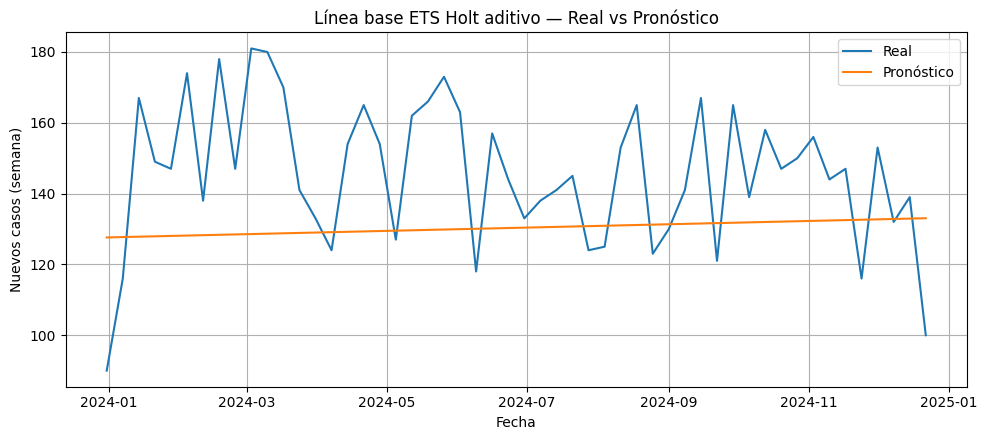

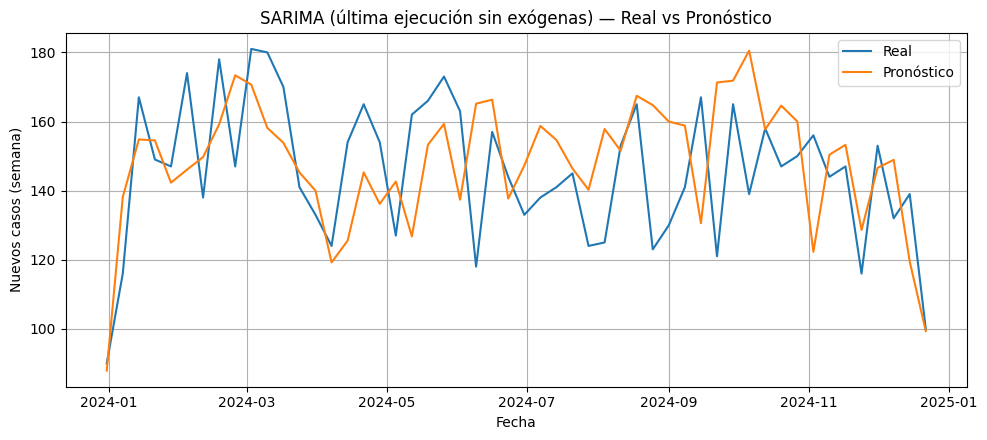

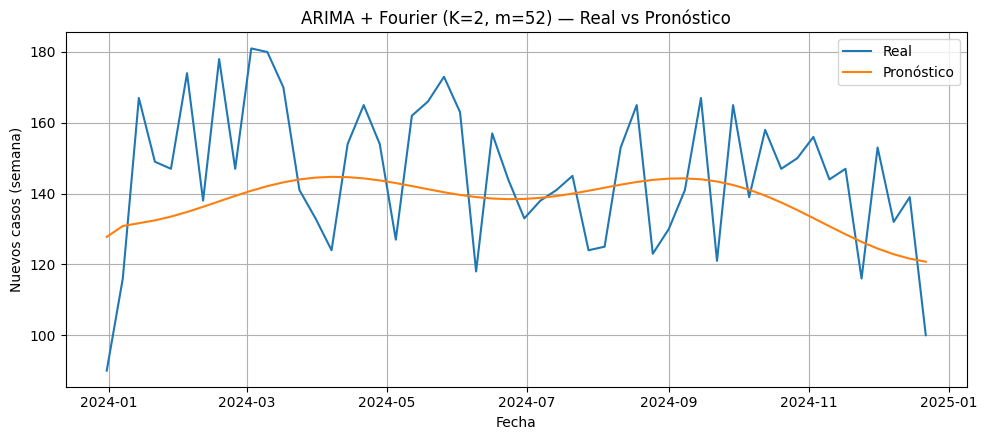

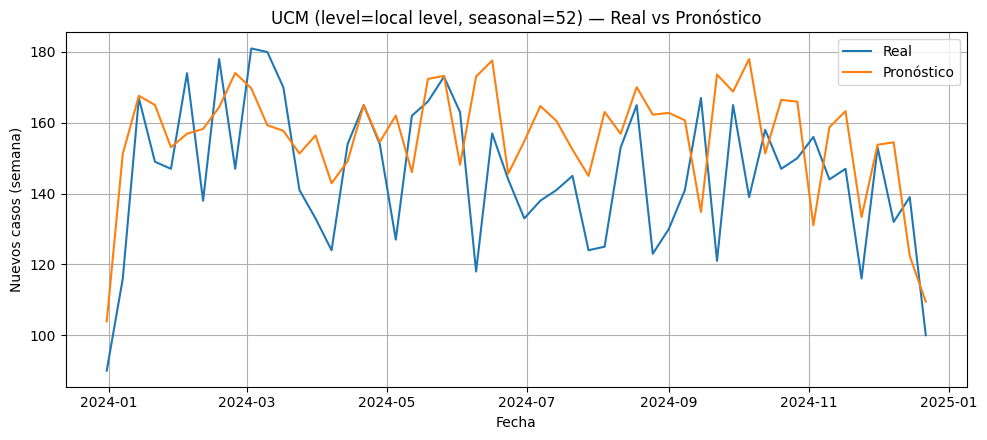

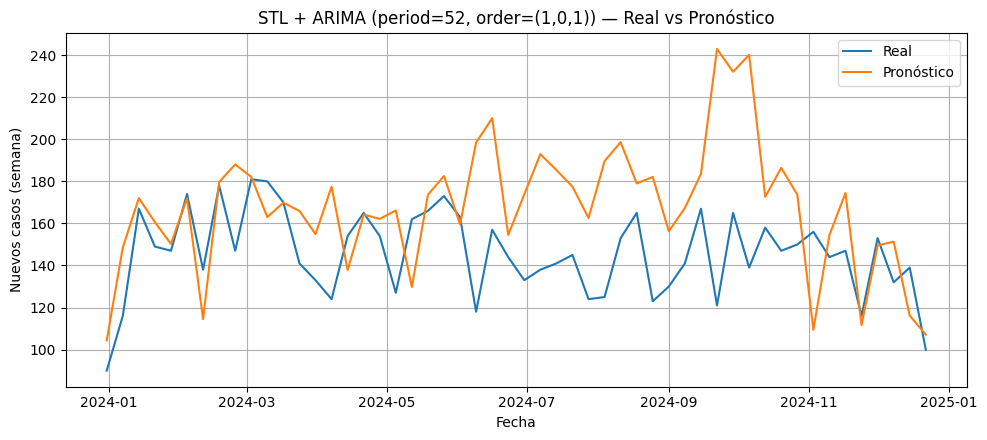

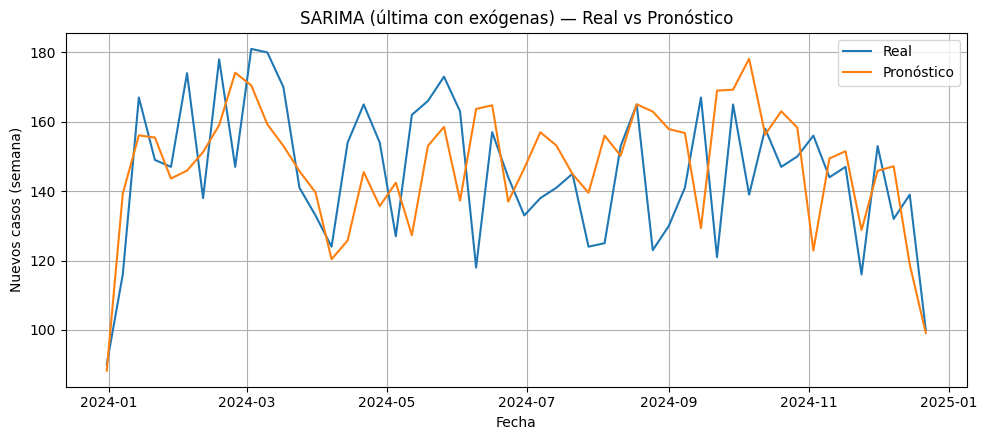

In [26]:
# Gráficas Real vs Pronóstico

# Serie real
y_true = y_test

# Helpers
def _to_series(x):
    if isinstance(x, pd.DataFrame) and x.shape[1] == 1:
        return x.iloc[:, 0]
    return x

def _align_series(y_real: pd.Series, y_pred):
    y_real = _to_series(y_real)
    y_pred = _to_series(y_pred)
    if not isinstance(y_pred.index, pd.DatetimeIndex):

        y_pred.index = y_real.index
    if not y_real.index.equals(y_pred.index):
        try:
            y_pred = y_pred.reindex(y_real.index)
        except Exception:
            common_idx = y_real.index.intersection(y_pred.index)
            y_real = y_real.loc[common_idx]
            y_pred = y_pred.loc[common_idx]
    return y_real, y_pred

def plot_forecast(y_real, y_pred, title, ylabel="Nuevos casos (semana)"):
    y_r, y_p = _align_series(y_real, y_pred)
    plt.figure(figsize=(10, 4.5))
    plt.plot(y_r.index, y_r.values, label="Real")
    plt.plot(y_p.index, y_p.values, label="Pronóstico")
    plt.title(f"{title} — Real vs Pronóstico")
    plt.xlabel("Fecha"); plt.ylabel(ylabel)
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()

# Construir el diccionario
model_forecasts = {}
def _add_if_exists(name, varname):
    if varname in globals() and globals()[varname] is not None:
        model_forecasts[name] = globals()[varname]

_add_if_exists("Línea base ETS Holt aditivo", "fc_ets")
_add_if_exists("SARIMA (última ejecución sin exógenas)", "fc_sarima")
_add_if_exists("ARIMA + Fourier (K=2, m=52)", "fc_af")
_add_if_exists("UCM (level=local level, seasonal=52)", "fc_ucm")
_add_if_exists("STL + ARIMA (period=52, order=(1,0,1))", "fc_stl")
_add_if_exists("SARIMA (última con exógenas)", "fc_sarima_x")

if not model_forecasts:
    raise ValueError("No encontré pronósticos fc_*. Ejecuta tus modelos antes de graficar.")

# Un gráfico por modelo
for name, fc in model_forecasts.items():
    plot_forecast(y_true, fc, title=name)

# Conclusiones finales

## Resultados clave

- **Línea base de comunicación:** *ETS Holt aditivo* — **sMAPE 14.94 %**, **MAE 21.11**, **RMSE 25.47** *(mejora fuerte vs. S-Naive 21.38 %)*.  
- **Mejor familia:** **SARIMA**  
- **SARIMA base** *(2, 0, 1)(0, 1, 1, 52)* → **sMAPE 11.82 %**, **MAE 17.51**, **RMSE 21.48**, **MASE 0.422**.  
- **SARIMA ajustado 4** *(3, 0, 2)(0, 1, 1, 52) + log1p + shocks)* → **sMAPE 11.26 % (↓ mejor)**, **MAE 16.50**, **RMSE 20.57**, **MASE 0.397**.  
- **Transformaciones log/log1p sin exógenas** → mejora leve (≈ 11.58 % sMAPE).

---

### Reflexión — ¿vale la pena la complejidad de las exógenas?

- **Ganancia vs. SARIMA base:** ≈ **0.56 p.p. en sMAPE** (~ **5 % relativo**), ↓ **RMSE ≈ 0.9** y ↓ **MASE (0.422 → 0.397)**.  
- **Costo / operación:** mantener exógenas de *shocks* (dummies poco frecuentes), mayor *tuning* y monitoreo.  
- **Lectura:** la mejora es **real pero moderada**.  
  - Si **simplicidad y resiliencia** son prioridad, **SARIMA base** es suficiente para capturar tendencia y estacionalidad.  
  - Si el objetivo es **minimizar el error** y se puede sostener el flujo de exógenas, **SARIMA + shocks** se justifica.

---

## Decisión propuesta

- MEJOR MODELO (orientado a desempeño):** **SARIMA ajustado 4 (log1p + shocks)**  
- **Challenger / opción operativa simple:** **SARIMA base**  
- **Baseline de control:** **ETS Holt aditivo** se conserva como referencia comparativa *(y **S-Naive** como piso)*.
